In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

print('Import successfull')

Import successfull


# Business Question 1 & 2
* How well can I predict my own salary
* Which are the most important coefficients that I could use to increase my income in the future

## Gather
### Import of the datasets
Used the results of the Stack Overflow surveys from 2017 and 2020, downloadable from [Stack Overflow](https://insights.stackoverflow.com/survey).

In [36]:
df_2017 = pd.read_csv('Data/survey_results_2017.csv', low_memory = False)
df_2017_personal = pd.read_csv(
    'Data/survey_results_2017_personal.csv', 
    low_memory = False
)

df_2020 = pd.read_csv('Data/survey_results_2020.csv', low_memory = False)

## Assess

There is very few intersecting columns between the 2017 and 2020 dataset, so their names have either been changed or the questions were different.

Looking at the surveys confirms, that in fact both of these are the case. 

In [37]:
print(df_2020.columns.intersection(df_2017.columns))

Index(['Respondent', 'Country', 'Gender'], dtype='object')


### Salary prediction 2017
What was my salary predection of 2017, according to how I personally would answer the survey questions?

## Clean

The ExpectedSalary column is dropped here as it is expected to be very close to the actual income and may render all ohter coefficients unimportant.

All rows that have NULL for their salary are dropped, as this is the target variable and can therefore not be null.

Null values for all numeric columns will be filled using the mean of the column. If any of the numeric columns leads to a very important coefficient, the impact of filling with the mean should be double checked. 

For categorical columns, they will be cleaned using dummy values.

In [38]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    '''

    
    df_clean = df.dropna(subset = ['Salary'])
    
    X = df_clean.drop(['Salary'], axis = 1)
    y = df_clean[['Salary', 'Respondent']]
    
    X.drop(['ExpectedSalary'], inplace = True, axis = 1)
    
    for col in X.columns:
        if X[col].dtype in ['float64', 'int']:
            X[col].fillna(X[col].mean(), inplace = True)
        elif col == 'Respondent':
            X[col]
        else:
            X = pd.concat(
                [
                    X.drop([col], axis = 1), 
                    pd.get_dummies(X[col], prefix = col, prefix_sep = '_', drop_first = True)
                ], 
                axis = 1
            )
    
    return X, y    

## Analyze

In [39]:
X_analyze, y_analyze = clean_data(df_2017)
print(X_analyze.head())
print(y_analyze.head())

    Respondent  CareerSatisfaction  JobSatisfaction  HoursPerWeek  \
2            3                 8.0              9.0       2.64292   
14          15                 8.0              8.0       2.64292   
17          18                 9.0              8.0       2.64292   
18          19                 5.0              3.0       2.64292   
22          23                 8.0              9.0       2.64292   

    StackOverflowSatisfaction  \
2                    8.000000   
14                   8.000000   
17                   8.000000   
18                   8.511858   
22                   8.000000   

    ProgramHobby_Yes, I contribute to open source projects  \
2                                                   0        
14                                                  0        
17                                                  0        
18                                                  0        
22                                                  0        

    ProgramHo

## Model

In [40]:
def grid_search_frac(df, frac):
    '''
    INPUT
    df - pandas dataframe
    frac - fraction of data to test
    
    OUTPUT
    r2 - r2 score of predicting with that fraction of the data
    '''
    
    df_sample = df.sample(frac = frac, replace = False, random_state = 187)
    X, y = clean_data(df_sample)
    X.loc[X['Respondent'] != 'Rob'].drop(['Respondent'], inplace = True, axis = 1)
    y.loc[X['Respondent'] != 'Rob'].drop(['Respondent'], inplace = True, axis = 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=187) 
    lm_model = LinearRegression(normalize = True)
    lm_model.fit(X_train, y_train)

    y_test_preds = lm_model.predict(X_test)
    return r2_score(y_test, y_test_preds), lm_model

Text(0, 0.5, 'R2 score')

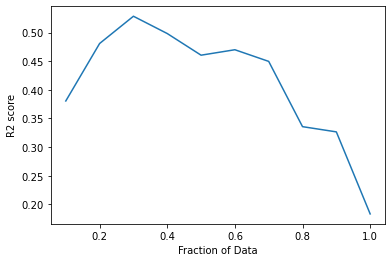

In [41]:
fracs = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
r2_scores = {}

for frac in fracs:
        r2, lm_model = grid_search_frac(df_2017, frac)
        r2_scores.update({frac: r2})

r2_scores_lists = sorted(r2_scores.items()) 
x_r2_scores, y_r2_scores = zip(*r2_scores_lists) 

plt.plot(x_r2_scores, y_r2_scores)
plt.xlabel("Fraction of Data")
plt.ylabel("R2 score")

Let's look at the lower fractions in further detail as they showed to be the most promising.

Text(0, 0.5, 'R2 score')

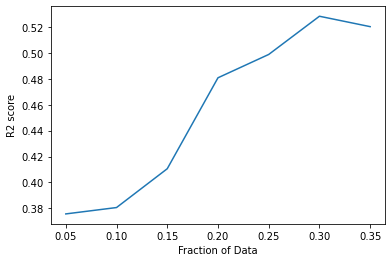

In [42]:
fracs = [.05, .1, .15, .2, .25 ,.3 , .35]
r2_scores = {}
lm_models = {}

for frac in fracs:
        r2, lm_model = grid_search_frac(df_2017, frac)
        r2_scores.update({frac: r2})
        lm_models.update({frac: lm_model})
        
r2_scores_lists = sorted(r2_scores.items()) 
x_r2_scores, y_r2_scores = zip(*r2_scores_lists) 

plt.plot(x_r2_scores, y_r2_scores)
plt.xlabel("Fraction of Data")
plt.ylabel("R2 score")

Training the model will be done with 30% of the avilable data as this show's to have the highest R2 score.

In [43]:
df_2017_sampled_full = df_2017.sample(
    frac = .3, 
    replace = False, 
    random_state = 187
).append(df_2017_personal)

x_full, y_full = clean_data(df_2017_sampled_full)
x_not_rob = x_full.loc[x_full['Respondent'] != 'Rob'].drop(['Respondent'], axis = 1)
y_not_rob = y_full.loc[y_full['Respondent'] != 'Rob'].drop(['Respondent'], axis = 1)

x_test_rob = x_full.loc[x_full['Respondent'] == 'Rob'].drop(['Respondent'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(
    x_not_rob, y_not_rob, test_size = .30, random_state=187) 
lm_model = LinearRegression(normalize = True)
lm_model.fit(X_train, y_train)

print("Predicted yearly Salary: {} €".format(lm_model.predict(x_test_rob)[0]))

Predicted yearly Salary: [51688.0949358] €


### Answer to question 1, how well can I predict my own salary:
That actually is not very far off. So according to this model, which steps should I take to increase my salary in the future?

## Visualize

In [44]:
coefs_df = pd.DataFrame()
coefs_df['Question Answer'] = X_train.columns
coefs_df['Coef'] = lm_model.coef_[0]
coefs_df = coefs_df.sort_values('Coef', ascending=False)

for coef in coefs_df['Question Answer']:
    print("Coefficient: {} | {}".format(
        coefs_df.loc[coefs_df["Question Answer"] == coef, "Coef"].values, coef
    ))
    

Coefficient: [83318.99459295] | MetricAssess_Commit frequency; On time/in budget; Peers' rating; Self-rating
Coefficient: [67604.9918681] | WantWorkLanguage_Ruby; Rust; SQL
Coefficient: [66596.28604607] | WantWorkFramework_AngularJS; Hadoop; Node.js; React; Xamarin
Coefficient: [60348.57274871] | ImportantBenefits_Equipment; Expected work hours; Remote options
Coefficient: [58923.35562351] | ImportantBenefits_Stock options; Professional development sponsorship; Expected work hours; Remote options
Coefficient: [57152.761739] | MetricAssess_Bugs found; Hours worked; Customer satisfaction; Benchmarked product performance; Revenue performance
Coefficient: [53858.44753132] | ImportantBenefits_Vacation/days off; Health benefits; Private office; Remote options; Child/elder care
Coefficient: [50973.85969894] | HaveWorkedLanguage_C++; Lua; Python
Coefficient: [49699.85464656] | HaveWorkedLanguage_C#; JavaScript; Perl; PHP; TypeScript
Coefficient: [49589.85646223] | HaveWorkedLanguage_F#; Haskel

Coefficient: [22234.84223808] | WantWorkPlatform_Android; Arduino; Raspberry Pi; Serverless; Amazon Web Services (AWS)
Coefficient: [22144.94314219] | ImportantBenefits_Vacation/days off; Health benefits; Equipment; Private office; Professional development sponsorship
Coefficient: [21844.4065342] | WantWorkLanguage_C#; Clojure; Erlang; Groovy; Haskell; Ruby; Scala
Coefficient: [21844.4065342] | IDE_Atom; Notepad++; Android Studio; Eclipse; IntelliJ; Visual Studio
Coefficient: [21839.8086582] | HaveWorkedLanguage_C; Java; JavaScript; Python; Swift
Coefficient: [21836.44704112] | HaveWorkedLanguage_C#; JavaScript; Python; TypeScript; Visual Basic 6
Coefficient: [21832.64269092] | HaveWorkedLanguage_Java; JavaScript; Objective-C; PHP
Coefficient: [21832.64269092] | IDE_NetBeans; Xcode
Coefficient: [21794.6093377] | ImportantBenefits_Stock options; Retirement; Vacation/days off; Expected work hours; Meals
Coefficient: [21753.84310924] | ImportantBenefits_Retirement; Health benefits; Equipm

Coefficient: [14401.08371874] | IDE_Atom; Emacs; Sublime Text; IntelliJ; PHPStorm; PyCharm
Coefficient: [14401.08371874] | WantWorkLanguage_Elixir; Erlang; Go; Julia; Python; Rust
Coefficient: [14395.61077304] | HaveWorkedLanguage_JavaScript; PHP; Python; SQL; VB.NET; VBA
Coefficient: [14371.78115653] | HaveWorkedLanguage_C#; Groovy; PHP; Python; Smalltalk
Coefficient: [14371.78115653] | WantWorkLanguage_Groovy; Python; Scala; Smalltalk
Coefficient: [14351.11216765] | HaveWorkedLanguage_C++; Java; JavaScript
Coefficient: [14345.17357513] | SelfTaughtTypes_Official documentation; Trade book; Built-in help; Other
Coefficient: [14332.59710079] | WantWorkLanguage_C#; F#; Go; JavaScript; SQL
Coefficient: [14322.0363159] | SelfTaughtTypes_Official documentation; Stack Overflow Q&A; Stack Overflow Docs; Non-Stack online communities; Friends network
Coefficient: [14318.83027689] | MetricAssess_Customer satisfaction; Benchmarked product performance; Other
Coefficient: [14315.41654574] | JobProf

Coefficient: [11252.01125733] | CousinEducation_Participate in hackathons; Participate in online coding competitions; Buy books and work through the exercises
Coefficient: [11244.17688187] | YearsCodedJob_8 to 9 years
Coefficient: [11214.06903791] | EducationTypes_Online course; Bootcamp; Part-time/evening course; On-the-job training; Self-taught
Coefficient: [11213.33167977] | ImportantBenefits_Stock options; Retirement; Health benefits; Equipment; Child/elder care
Coefficient: [11210.28121286] | Currency_Swiss francs
Coefficient: [11204.18158936] | ImportantBenefits_Retirement; Vacation/days off; Expected work hours; Remote options
Coefficient: [11178.42316099] | HaveWorkedLanguage_JavaScript; Python; Ruby; SQL; TypeScript
Coefficient: [11164.85065249] | WantWorkLanguage_Python; SQL; TypeScript
Coefficient: [11163.62480998] | WantWorkPlatform_Mac OS; Arduino; Raspberry Pi; Amazon Web Services (AWS)
Coefficient: [11163.5630541] | IDE_Notepad++; Android Studio; IntelliJ; Xcode
Coeffici

Coefficient: [9792.00092896] | MetricAssess_Benchmarked product performance; Manager's rating; Peers' rating
Coefficient: [9739.91285267] | WantWorkPlatform_Android; iOS; Windows Desktop; Linux Desktop; Mac OS; Arduino; Raspberry Pi; WordPress; Amazon Web Services (AWS)
Coefficient: [9736.48066761] | WantWorkLanguage_C#; F#; Go; Python; TypeScript
Coefficient: [9728.38848589] | WantWorkLanguage_Assembly; JavaScript; Rust; TypeScript
Coefficient: [9728.38848589] | HaveWorkedLanguage_C++; JavaScript; SQL
Coefficient: [9728.38848589] | CousinEducation_Get a job as a QA tester; Contribute to open source; Participate in hackathons; Buy books and work through the exercises
Coefficient: [9690.3217822] | DeveloperType_Desktop applications developer; Database administrator; Other
Coefficient: [9676.73641695] | HaveWorkedPlatform_Linux Desktop; Mac OS; Amazon Web Services (AWS)
Coefficient: [9659.46064914] | HaveWorkedDatabase_Redis; SQL Server; MySQL; PostgreSQL
Coefficient: [9657.61301961] | S

Coefficient: [8452.73825548] | ImportantBenefits_Stock options; Retirement; Annual bonus; Equipment; Remote options
Coefficient: [8449.8339706] | ImportantBenefits_Stock options; Vacation/days off; Equipment; Meals
Coefficient: [8439.68285623] | MetricAssess_Hours worked; Benchmarked product performance; On time/in budget; Revenue performance; Peers' rating
Coefficient: [8427.05939727] | ImportantBenefits_Retirement; Health benefits; Equipment; Remote options
Coefficient: [8418.817322] | HaveWorkedFramework_AngularJS; Firebase
Coefficient: [8384.11811786] | ImportantBenefits_Health benefits; Equipment; Professional development sponsorship; Expected work hours; Child/elder care
Coefficient: [8348.68859015] | HaveWorkedLanguage_Hack; Java; JavaScript; Matlab; SQL
Coefficient: [8348.68859015] | HaveWorkedFramework_React; Spark
Coefficient: [8348.68859015] | WantWorkLanguage_C++; CoffeeScript; Python
Coefficient: [8339.48277643] | ImportantBenefits_Retirement; Vacation/days off; Profession

Coefficient: [6402.51747635] | HaveWorkedLanguage_C#; Go; JavaScript; SQL; Swift; VB.NET
Coefficient: [6402.51747635] | IDE_Vim; Visual Studio; Visual Studio Code; Xcode
Coefficient: [6399.70736221] | HaveWorkedLanguage_Java; JavaScript; Lua; PHP; SQL
Coefficient: [6395.25010896] | ImportantBenefits_Retirement; Health benefits; Long-term leave; Expected work hours; Remote options
Coefficient: [6391.13866995] | IDE_Emacs; Sublime Text; IPython / Jupyter
Coefficient: [6391.04483119] | WantWorkPlatform_iOS; Amazon Web Services (AWS)
Coefficient: [6388.32877621] | VersionControl_Rational ClearCase
Coefficient: [6388.16371269] | ImportantBenefits_Vacation/days off; Professional development sponsorship; Expected work hours; Remote options
Coefficient: [6386.90615873] | ImportantBenefits_Annual bonus; Charitable match; Equipment; Professional development sponsorship
Coefficient: [6378.84551826] | ImportantBenefits_Stock options; Annual bonus; Vacation/days off; Equipment
Coefficient: [6369.85

Coefficient: [5404.61049889] | SelfTaughtTypes_Official documentation; Non-Stack online communities; Company internal community; Built-in help
Coefficient: [5399.69327146] | HaveWorkedLanguage_Ruby; SQL
Coefficient: [5398.89726728] | ImportantBenefits_Retirement; Vacation/days off; Health benefits; Private office; Expected work hours
Coefficient: [5398.28620777] | IDE_Emacs
Coefficient: [5394.43826103] | DeveloperType_Data scientist; Desktop applications developer; Database administrator
Coefficient: [5378.74870127] | HaveWorkedLanguage_Java; JavaScript; Ruby; Scala
Coefficient: [5378.74870127] | HaveWorkedDatabase_Cassandra; MongoDB; Redis; MySQL; PostgreSQL; Oracle
Coefficient: [5377.3966367] | ImportantBenefits_Annual bonus; Vacation/days off; Health benefits; Professional development sponsorship
Coefficient: [5376.99792572] | SelfTaughtTypes_Official documentation; Trade book; Textbook; Stack Overflow Docs; Non-Stack online communities
Coefficient: [5365.44232419] | CousinEducation

Coefficient: [4778.05404219] | WantWorkFramework_Node.js; React; .NET Core
Coefficient: [4776.83172352] | ImportantBenefits_Retirement; Vacation/days off; Private office; Remote options; Meals
Coefficient: [4775.58345705] | CousinEducation_Buy books and work through the exercises
Coefficient: [4773.51316516] | WantWorkLanguage_Elixir; JavaScript; Ruby; SQL; TypeScript
Coefficient: [4770.01543873] | WantWorkLanguage_Java; JavaScript; PHP; Scala; SQL; TypeScript
Coefficient: [4763.34600874] | IDE_Notepad++; Sublime Text; Android Studio; NetBeans; Visual Studio; Visual Studio Code; Xcode
Coefficient: [4763.34600874] | WantWorkLanguage_C++; C#; Java; JavaScript; Python; SQL
Coefficient: [4763.34600874] | MetricAssess_Commit frequency; Customer satisfaction; Benchmarked product performance; Revenue performance; Manager's rating; Peers' rating; Self-rating
Coefficient: [4763.34600874] | HaveWorkedLanguage_C#; CoffeeScript; Java; JavaScript; Objective-C; PHP; Python; SQL
Coefficient: [4762.06

Coefficient: [4107.49816986] | IDE_Notepad++; Vim; IPython / Jupyter; PyCharm
Coefficient: [4107.49816986] | HaveWorkedLanguage_C#; Matlab; Python
Coefficient: [4105.33350812] | HaveWorkedPlatform_iOS; Amazon Web Services (AWS)
Coefficient: [4098.66123854] | WorkStart_9:00 PM
Coefficient: [4095.29647744] | ImportantBenefits_Vacation/days off; Private office; Expected work hours; Meals; Other
Coefficient: [4091.76104825] | ImportantBenefits_Vacation/days off; Professional development sponsorship; Expected work hours; Remote options; Meals
Coefficient: [4078.24773989] | ImportantBenefits_Stock options; Equipment; Expected work hours; Remote options; Meals
Coefficient: [4070.92567257] | CousinEducation_Contribute to open source; Bootcamp; Participate in online coding competitions; Buy books and work through the exercises
Coefficient: [4069.91692915] | EducationTypes_Online course; On-the-job training
Coefficient: [4052.63691853] | ImportantBenefits_Retirement; Vacation/days off; Equipment

Coefficient: [3232.71548738] | WantWorkLanguage_C#; F#; Go; TypeScript
Coefficient: [3232.31801256] | ImportantBenefits_Retirement; Annual bonus; Vacation/days off; Health benefits; Equipment
Coefficient: [3226.78300311] | Methodology_Agile; Lean
Coefficient: [3225.37701292] | SelfTaughtTypes_Official documentation; Trade book; Stack Overflow Q&A; Stack Overflow Docs; Non-Stack online communities; Friends network
Coefficient: [3222.4630612] | WantWorkPlatform_Raspberry Pi; WordPress; Amazon Web Services (AWS)
Coefficient: [3218.33190065] | EducationTypes_Online course; Part-time/evening course; Industry certification; On-the-job training; Self-taught; Hackathon
Coefficient: [3213.10614367] | HaveWorkedPlatform_iOS; Serverless
Coefficient: [3213.10614367] | IDE_Vim; IntelliJ; Xcode
Coefficient: [3213.10614367] | WantWorkLanguage_Elixir; Rust; Scala
Coefficient: [3211.84809572] | CousinEducation_Return to college; Get a job as a QA tester; Bootcamp; Part-time/evening courses
Coefficient:

Coefficient: [2547.92465689] | HaveWorkedLanguage_Java; JavaScript; Python; R; Scala; SQL
Coefficient: [2547.92465689] | WantWorkPlatform_Raspberry Pi; Serverless; Microsoft Azure
Coefficient: [2547.92465689] | MetricAssess_Release frequency; Peers' rating
Coefficient: [2547.92465689] | IDE_Notepad++; Sublime Text; Vim; IntelliJ; RStudio
Coefficient: [2547.92465689] | WantWorkLanguage_CoffeeScript; Clojure; Erlang; Go; Haskell; Swift
Coefficient: [2542.90200458] | WantWorkLanguage_Go; Haskell; JavaScript; Ruby; SQL
Coefficient: [2538.35353585] | WantWorkLanguage_C++; C#; F#; Python; SQL; Swift
Coefficient: [2538.35353585] | HaveWorkedLanguage_C#; F#; JavaScript; Python; SQL; Swift; TypeScript; VB.NET
Coefficient: [2538.35353585] | HaveWorkedPlatform_iOS; Windows Desktop; Mac OS; Salesforce; Amazon Web Services (AWS)
Coefficient: [2538.13183416] | HaveWorkedPlatform_Windows Desktop; Linux Desktop; WordPress
Coefficient: [2538.05028436] | WantWorkLanguage_C; C++; JavaScript; Python; SQL


Coefficient: [2043.80208817] | CousinEducation_Get a job as a QA tester; Participate in online coding competitions; Buy books and work through the exercises
Coefficient: [2042.23039618] | HaveWorkedLanguage_C#; Go; SQL
Coefficient: [2042.23039618] | WantWorkLanguage_Go; SQL
Coefficient: [2039.58404654] | Race_East Asian; White or of European descent
Coefficient: [2039.55379671] | IDE_Sublime Text; PHPStorm
Coefficient: [2037.9502835] | IDE_Atom; Notepad++; Android Studio; IntelliJ; PyCharm; Visual Studio
Coefficient: [2037.9502835] | HaveWorkedLanguage_C++; C#; Elixir; Erlang; Haskell; Java; JavaScript; Matlab; PHP; Python; SQL
Coefficient: [2037.9502835] | WantWorkLanguage_C++; C#; CoffeeScript; Elixir; Erlang; Haskell; Java; JavaScript; Lua; Matlab; PHP; SQL; TypeScript
Coefficient: [2036.84841509] | CousinEducation_Get a job as a QA tester; Contribute to open source; Buy books and work through the exercises; Conferences/meet-ups
Coefficient: [2030.96046855] | WantWorkPlatform_Androi

Coefficient: [1719.21556204] | SelfTaughtTypes_Official documentation; Stack Overflow Docs; Company internal community; Tutoring/mentoring; Other
Coefficient: [1717.72819261] | WantWorkLanguage_C#; F#; Java; JavaScript; Python; R; TypeScript
Coefficient: [1717.72819261] | WantWorkPlatform_Windows Desktop; Linux Desktop; Mac OS; Arduino; Amazon Web Services (AWS); Microsoft Azure
Coefficient: [1717.72819261] | IDE_Atom; Eclipse; PyCharm; Visual Studio; Visual Studio Code
Coefficient: [1715.51966737] | HaveWorkedPlatform_Android; iOS; Windows Desktop; Linux Desktop; Mac OS; Microsoft Azure
Coefficient: [1709.88893616] | JobProfile_Glassdoor; LinkedIn; Other
Coefficient: [1704.38786678] | CousinEducation_Take online courses; Part-time/evening courses; Participate in online coding competitions
Coefficient: [1702.65225699] | WantWorkLanguage_Java; Python; Scala
Coefficient: [1696.36220079] | MetricAssess_Commit frequency; Customer satisfaction; Benchmarked product performance; Revenue perfo

Coefficient: [1366.99706821] | ResumePrompted_Something else
Coefficient: [1366.11596809] | WantWorkPlatform_Android; Windows Phone; Windows Desktop; Amazon Web Services (AWS)
Coefficient: [1365.91980966] | CousinEducation_Get a job as a QA tester; Contribute to open source; Conferences/meet-ups
Coefficient: [1365.86079828] | SelfTaughtTypes_Official documentation; Trade book; Textbook; Stack Overflow Q&A; Stack Overflow Docs
Coefficient: [1365.82695158] | MetricAssess_On time/in budget; Manager's rating; Peers' rating
Coefficient: [1361.43439156] | StackOverflowDevices_Desktop; iOS browser
Coefficient: [1361.04364373] | WantWorkDatabase_Redis; MySQL; PostgreSQL
Coefficient: [1360.93081961] | EducationTypes_Self-taught; Hackathon; Open source contributions
Coefficient: [1358.93986321] | WantWorkDatabase_Redis; SQL Server; MySQL; Oracle
Coefficient: [1353.99751167] | WantWorkPlatform_Android; Windows Desktop; Mac OS
Coefficient: [1353.99751167] | WantWorkLanguage_C; C++; C#; Java; JavaS

Coefficient: [1051.14532475] | InfluenceDeptTech_I am the final decision maker
Coefficient: [1051.06144316] | DeveloperType_Desktop applications developer; Database administrator; Systems administrator; DevOps specialist
Coefficient: [1050.93234316] | DeveloperType_Mobile developer; Graphics programming; Data scientist
Coefficient: [1046.92108947] | WantWorkLanguage_C++; C#; Java; JavaScript; PHP; Python; SQL
Coefficient: [1043.97442195] | DeveloperType_Web developer; Developer with a statistics or mathematics background; DevOps specialist
Coefficient: [1041.61608023] | DeveloperType_Web developer; Embedded applications/devices developer; Developer with a statistics or mathematics background; Desktop applications developer
Coefficient: [1039.95888203] | DeveloperType_Mobile developer; Desktop applications developer; Quality assurance engineer
Coefficient: [1039.39682125] | HaveWorkedLanguage_C; C++; C#; JavaScript; PHP; Python; SQL; TypeScript
Coefficient: [1039.39682125] | WantWorkPla

Coefficient: [762.62971877] | HaveWorkedFramework_AngularJS; Node.js; Cordova; Xamarin; .NET Core
Coefficient: [760.79960129] | ImportantBenefits_Retirement; Vacation/days off; Equipment; Professional development sponsorship
Coefficient: [760.77604443] | Methodology_Agile; Lean; Scrum; Pair; Domain-driven design
Coefficient: [760.77604443] | HaveWorkedLanguage_C; C++; JavaScript; Python; Scala; TypeScript
Coefficient: [760.77604443] | IDE_Atom; Sublime Text; IntelliJ; IPython / Jupyter
Coefficient: [760.12922499] | HaveWorkedLanguage_C#; JavaScript; SQL
Coefficient: [759.93687501] | SelfTaughtTypes_Tutoring/mentoring; Friends network; Built-in help
Coefficient: [759.93519769] | EducationTypes_Online course; Part-time/evening course; On-the-job training; Hackathon; Open source contributions
Coefficient: [759.53955885] | HaveWorkedLanguage_C#; R; SQL; TypeScript
Coefficient: [759.53955885] | WantWorkLanguage_Erlang
Coefficient: [758.64755209] | ImportantHiringTitles_Not at all important


Coefficient: [524.05271738] | DeveloperType_Mobile developer; Other
Coefficient: [522.38456517] | Methodology_Agile; Lean; Scrum; Extreme; Pair; Kanban
Coefficient: [520.22609036] | HaveWorkedPlatform_Linux Desktop; Amazon Web Services (AWS)
Coefficient: [519.31786961] | LearnedHiring_A tech-specific job board
Coefficient: [519.26431809] | Methodology_Agile; Scrum; Extreme; Kanban
Coefficient: [515.36809853] | JobProfile_Indeed; LinkedIn; Naukri; Other
Coefficient: [512.41078273] | WantWorkFramework_AngularJS
Coefficient: [508.01711712] | WantWorkPlatform_Amazon Web Services (AWS); Microsoft Azure
Coefficient: [505.36855048] | AssessJobIndustry_Somewhat important
Coefficient: [503.67665778] | AssessJobTech_Not very important
Coefficient: [501.99738059] | AssessJobProfDevel_Not at all important
Coefficient: [501.68494672] | HaveWorkedLanguage_Assembly; C; C++; JavaScript; Julia; Python; R; Rust; SQL; Swift
Coefficient: [500.99936004] | Methodology_Agile; Lean; Scrum; Extreme; Pair; Kanb

Coefficient: [234.75778023] | DeveloperType_Web developer; Mobile developer; Embedded applications/devices developer; Graphics programming; Data scientist; Desktop applications developer; Database administrator; Systems administrator; Quality assurance engineer
Coefficient: [233.70655329] | MetricAssess_Customer satisfaction; Benchmarked product performance; On time/in budget; Revenue performance; Manager's rating; Peers' rating; Self-rating
Coefficient: [233.24774192] | WantWorkLanguage_C#
Coefficient: [232.72215161] | ImportantBenefits_Stock options; Remote options
Coefficient: [232.11205449] | ImportantHiringCommunication_Very important
Coefficient: [231.39267611] | WantWorkLanguage_C++; C#; Go; Haskell; JavaScript; Python
Coefficient: [231.39267611] | HaveWorkedLanguage_C++; C#; JavaScript; Python; Rust
Coefficient: [230.59321558] | DifficultCommunication_Somewhat agree
Coefficient: [227.14685249] | ImportantBenefits_Annual bonus; Vacation/days off; Private office; Remote options; 

Coefficient: [86.12201908] | ImportantBenefits_Retirement; Annual bonus; Vacation/days off; Health benefits; Private office
Coefficient: [84.20000884] | ImportantBenefits_Vacation/days off; Health benefits; Professional development sponsorship; Long-term leave; Remote options
Coefficient: [82.62820762] | IDE_Notepad++; Sublime Text; Android Studio; Visual Studio; Visual Studio Code
Coefficient: [82.43506333] | BuildingThings_Strongly agree
Coefficient: [82.25833713] | ImportantBenefits_Vacation/days off; Long-term leave; Expected work hours; Remote options; Child/elder care
Coefficient: [81.27076585] | HaveWorkedDatabase_MySQL; Oracle; SQLite
Coefficient: [80.91216419] | TimeAfterBootcamp_Six months to a year
Coefficient: [80.45311188] | WantWorkDatabase_MongoDB; Oracle
Coefficient: [79.97341303] | IDE_Notepad++; Vim; PHPStorm; Visual Studio; Visual Studio Code
Coefficient: [79.8886287] | DeveloperType_Web developer; Mobile developer; Desktop applications developer; Database administra

Coefficient: [0.] | CousinEducation_Master's degree; Buy books and work through the exercises; Conferences/meet-ups
Coefficient: [0.] | WantWorkLanguage_C#; Lua; TypeScript
Coefficient: [0.] | IDE_Atom; Notepad++; Sublime Text; Android Studio; Eclipse; PHPStorm
Coefficient: [0.] | IDE_Atom; Notepad++; Sublime Text; Android Studio; IntelliJ; NetBeans; Visual Studio
Coefficient: [0.] | IDE_Atom; Notepad++; Sublime Text; Android Studio; IntelliJ; Visual Studio; Visual Studio Code; Xcode
Coefficient: [0.] | IDE_Atom; Notepad++; Sublime Text; Eclipse; IntelliJ; IPython / Jupyter; RStudio; RubyMine; Visual Studio Code
Coefficient: [0.] | CousinEducation_Get a job as a QA tester; Bootcamp; Part-time/evening courses; Conferences/meet-ups
Coefficient: [0.] | WantWorkLanguage_C#; JavaScript; Scala; SQL; TypeScript
Coefficient: [0.] | IDE_Emacs; Eclipse; Komodo
Coefficient: [0.] | IDE_Atom; Vim; IPython / Jupyter; RStudio; Visual Studio Code
Coefficient: [0.] | HaveWorkedFramework_AngularJS; Hado

Coefficient: [0.] | WantWorkLanguage_C++; Common Lisp; F#; Java; JavaScript; Matlab; PHP; Python; SQL
Coefficient: [0.] | SelfTaughtTypes_Trade book; Textbook; Stack Overflow Q&A; Stack Overflow Docs; Non-Stack online communities; Tutoring/mentoring; Friends network
Coefficient: [0.] | WantWorkPlatform_iOS; Mac OS; Arduino; Salesforce
Coefficient: [0.] | WantWorkLanguage_C++; CoffeeScript; Common Lisp; Go; Hack; Haskell; Java; JavaScript; Perl; Python; R; Ruby; SQL
Coefficient: [0.] | WantWorkLanguage_F#; Haskell; TypeScript
Coefficient: [0.] | WantWorkLanguage_C++; CoffeeScript
Coefficient: [0.] | WantWorkLanguage_C++; Clojure; Python
Coefficient: [0.] | WantWorkLanguage_C++; Clojure; JavaScript; Rust
Coefficient: [0.] | WantWorkLanguage_C++; Clojure; Java; JavaScript; TypeScript
Coefficient: [0.] | WantWorkLanguage_C++; Clojure; Go; Python; Rust
Coefficient: [0.] | WantWorkLanguage_C++; Clojure; Go; Python; Ruby; Scala; Swift
Coefficient: [0.] | WantWorkLanguage_F#; Java; JavaScript;

Coefficient: [0.] | MetricAssess_Bugs found; Customer satisfaction; On time/in budget; Manager's rating; Peers' rating; Other
Coefficient: [0.] | HaveWorkedLanguage_CoffeeScript; Java; JavaScript; Python; TypeScript
Coefficient: [0.] | MetricAssess_Bugs found; Commit frequency; On time/in budget
Coefficient: [0.] | HaveWorkedLanguage_C; Java; JavaScript; Objective-C; Smalltalk; Swift
Coefficient: [0.] | MetricAssess_Bugs found; Commit frequency; Customer satisfaction; Self-rating
Coefficient: [0.] | HaveWorkedLanguage_Dart; Go; Groovy; Java; JavaScript; Python; Ruby; SQL; Swift; TypeScript
Coefficient: [0.] | HaveWorkedLanguage_Common Lisp; Java; JavaScript; Python; SQL
Coefficient: [0.] | HaveWorkedLanguage_Common Lisp; Java; JavaScript; PHP; Ruby
Coefficient: [0.] | MetricAssess_Bugs found; Benchmarked product performance; On time/in budget; Manager's rating; Peers' rating
Coefficient: [0.] | MetricAssess_Bugs found; Benchmarked product performance; On time/in budget; Peers' rating; 

Coefficient: [0.] | HaveWorkedLanguage_C#; Java; JavaScript; Lua; Python; SQL
Coefficient: [0.] | HaveWorkedLanguage_C#; Java; Objective-C; Ruby; Swift; VB.NET
Coefficient: [0.] | MetricAssess_Lines of code; Bugs found; Commit frequency; On time/in budget; Peers' rating; Self-rating
Coefficient: [0.] | MetricAssess_Hours worked; Release frequency; Customer satisfaction; Benchmarked product performance; On time/in budget; Revenue performance; Manager's rating; Self-rating
Coefficient: [0.] | MetricAssess_Hours worked; Release frequency; Customer satisfaction; On time/in budget; Manager's rating; Peers' rating; Self-rating
Coefficient: [0.] | MetricAssess_Hours worked; Release frequency; Customer satisfaction; On time/in budget; Peers' rating
Coefficient: [0.] | MetricAssess_Hours worked; Release frequency; Customer satisfaction; Peers' rating
Coefficient: [0.] | MetricAssess_Hours worked; Release frequency; Manager's rating; Peers' rating
Coefficient: [0.] | MetricAssess_Hours worked; R

Coefficient: [0.] | WantWorkLanguage_Assembly; C; JavaScript; PHP; Python
Coefficient: [0.] | HaveWorkedPlatform_Android; Linux Desktop; Raspberry Pi; WordPress; Amazon Web Services (AWS)
Coefficient: [0.] | HaveWorkedPlatform_Android; Linux Desktop; Raspberry Pi; WordPress
Coefficient: [0.] | CousinEducation_Return to college; Buy books and work through the exercises; Conferences/meet-ups
Coefficient: [0.] | CousinEducation_Return to college; Contribute to open source; Bootcamp; Conferences/meet-ups
Coefficient: [0.] | IDE_Notepad++; Sublime Text; Vim; IntelliJ; PyCharm; Visual Studio; Visual Studio Code
Coefficient: [0.] | IDE_Notepad++; Sublime Text; Vim; NetBeans; Visual Studio
Coefficient: [0.] | IDE_Notepad++; Sublime Text; Vim; Visual Studio
Coefficient: [0.] | IDE_Notepad++; Sublime Text; Visual Studio Code
Coefficient: [0.] | IDE_Notepad++; TextMate; PHPStorm; Visual Studio
Coefficient: [0.] | WantWorkLanguage_Assembly; C; Common Lisp; Java; Python; Scala; SQL
Coefficient: [0.

Coefficient: [-8.83913027] | ImportantBenefits_Annual bonus; Health benefits; Professional development sponsorship; Education sponsorship; Other
Coefficient: [-9.14343671] | HaveWorkedFramework_AngularJS; Hadoop; Node.js; .NET Core
Coefficient: [-9.38609737] | ImportantBenefits_Stock options; Retirement; Professional development sponsorship; Education sponsorship; Long-term leave
Coefficient: [-10.13251991] | InfluenceWorkstation_Some influence
Coefficient: [-10.29540984] | ImportantBenefits_Retirement; Annual bonus; Vacation/days off; Charitable match; Health benefits
Coefficient: [-11.07367137] | InfluenceVizTools_I am the final decision maker
Coefficient: [-13.28610798] | CousinEducation_Take online courses; Participate in online coding competitions
Coefficient: [-13.51199046] | EducationTypes_Part-time/evening course; Self-taught; Coding competition
Coefficient: [-13.55988147] | SelfTaughtTypes_Official documentation; Trade book; Textbook; Stack Overflow Q&A; Non-Stack online commu

Coefficient: [-145.16461056] | ImportantBenefits_Stock options; Vacation/days off; Health benefits; Expected work hours; Other
Coefficient: [-145.38199068] | WorkStart_6:00 PM
Coefficient: [-145.71158915] | WantWorkFramework_Node.js; React; Firebase; .NET Core
Coefficient: [-149.34424168] | Country_Martinique (French)
Coefficient: [-149.78740349] | SelfTaughtTypes_Official documentation; Textbook; Non-Stack online communities; Company internal community; Built-in help
Coefficient: [-150.54720648] | ImportantBenefits_Retirement; Vacation/days off; Professional development sponsorship; Expected work hours; Other
Coefficient: [-151.92046339] | CollaborateRemote_Disagree
Coefficient: [-152.21608612] | ImportantBenefits_Stock options; Annual bonus; Health benefits; Equipment; Long-term leave
Coefficient: [-152.28535598] | DeveloperType_Web developer; Mobile developer; Embedded applications/devices developer; Data scientist; Desktop applications developer; Database administrator; Systems adm

Coefficient: [-338.97811222] | MetricAssess_Bugs found; Customer satisfaction; Benchmarked product performance; Revenue performance; Peers' rating
Coefficient: [-340.23285247] | DeveloperType_Web developer; Desktop applications developer; Database administrator
Coefficient: [-341.02764175] | DeveloperType_Web developer; Machine learning specialist; Developer with a statistics or mathematics background; Data scientist; Desktop applications developer
Coefficient: [-341.45759594] | ResumePrompted_I received bad news about the future of my company or depart
Coefficient: [-341.60118371] | DeveloperType_Web developer; Mobile developer; Machine learning specialist; Data scientist
Coefficient: [-341.81330379] | HaveWorkedLanguage_Assembly; C; C++; JavaScript; Lua; Matlab; PHP; Python; SQL
Coefficient: [-341.81330379] | WantWorkLanguage_Assembly; C; C++; C#; Haskell; Rust
Coefficient: [-343.03981096] | ImportantBenefits_Vacation/days off; Health benefits; Private office; Professional developmen

Coefficient: [-544.93581182] | ImportantBenefits_Health benefits; Private office; Professional development sponsorship; Remote options
Coefficient: [-546.23284056] | ImportantHiringRep_Not very important
Coefficient: [-546.73165699] | HaveWorkedLanguage_Java; JavaScript; PHP; SQL; VB.NET; VBA; Visual Basic 6
Coefficient: [-546.73165699] | HaveWorkedPlatform_Android; Windows Desktop; Linux Desktop; WordPress
Coefficient: [-546.73165699] | WantWorkPlatform_Android; iOS; Windows Desktop; Linux Desktop; Raspberry Pi; WordPress
Coefficient: [-550.54404727] | MetricAssess_Lines of code; Bugs found; Hours worked; Commit frequency; Release frequency; Customer satisfaction; Benchmarked product performance; On time/in budget; Revenue performance; Manager's rating; Peers' rating; Self-rating
Coefficient: [-552.30638261] | CousinEducation_Master's degree; Bootcamp; Part-time/evening courses; Buy books and work through the exercises
Coefficient: [-552.30638261] | WantWorkLanguage_C; C#; JavaScript;

Coefficient: [-859.61767377] | AssessJobCompensation_Not very important
Coefficient: [-860.59003603] | DeveloperType_Web developer; Mobile developer; Embedded applications/devices developer; Desktop applications developer; DevOps specialist
Coefficient: [-866.40087618] | HaveWorkedDatabase_MongoDB; SQL Server
Coefficient: [-866.923537] | CheckInCode_Just a few times over the year
Coefficient: [-867.2734981] | ImportantBenefits_Retirement; Vacation/days off; Health benefits; Education sponsorship
Coefficient: [-868.92556049] | IDE_Notepad++; Sublime Text; IntelliJ; Visual Studio
Coefficient: [-868.92556049] | WantWorkLanguage_C; C#; SQL; TypeScript
Coefficient: [-869.21244511] | HaveWorkedLanguage_CoffeeScript; Go; Groovy; Java; Objective-C; PHP; Ruby; SQL; TypeScript; VBA
Coefficient: [-869.21244511] | WantWorkLanguage_Go; Java; PHP; Python; R; SQL; Swift; TypeScript
Coefficient: [-876.76267019] | AssessJobLeaders_Not very important
Coefficient: [-878.16045909] | SelfTaughtTypes_Offici

Coefficient: [-1145.81174148] | IDE_Coda; Notepad++; Sublime Text; Android Studio; Visual Studio; Visual Studio Code
Coefficient: [-1145.81174148] | HaveWorkedPlatform_Android; Windows Desktop; Linux Desktop; Mac OS; Raspberry Pi; SharePoint; WordPress
Coefficient: [-1146.35287438] | ImportantBenefits_Retirement; Annual bonus; Vacation/days off; Health benefits; Expected work hours
Coefficient: [-1148.76586791] | DeveloperType_Web developer; Mobile developer; Developer with a statistics or mathematics background
Coefficient: [-1148.82046247] | StackOverflowCopiedCode_At least once each week
Coefficient: [-1152.30600491] | WantWorkLanguage_Elixir; Go; Java; Scala
Coefficient: [-1152.30600491] | HaveWorkedDatabase_Cassandra; MongoDB; Redis; SQL Server
Coefficient: [-1156.01500829] | HaveWorkedLanguage_Groovy; Java; JavaScript; Julia; SQL
Coefficient: [-1156.01500829] | WantWorkLanguage_Groovy; Java; JavaScript; Julia; Scala; SQL
Coefficient: [-1157.77521318] | IDE_Notepad++; Sublime Text

Coefficient: [-1392.66601881] | CousinEducation_Return to college; Take online courses; Bootcamp; Part-time/evening courses
Coefficient: [-1392.77291643] | StackOverflowDevices_Desktop; Android browser
Coefficient: [-1394.98167397] | WantWorkLanguage_C; C++; Python
Coefficient: [-1396.17422769] | ImportantHiringCompanies_Not at all important
Coefficient: [-1400.21884674] | ImportantBenefits_Education sponsorship; Expected work hours; Remote options; Child/elder care; Meals
Coefficient: [-1400.29641143] | HighestEducationParents_Primary/elementary school
Coefficient: [-1400.70403438] | DeveloperType_Web developer; Mobile developer; Embedded applications/devices developer; Desktop applications developer; Database administrator; Systems administrator
Coefficient: [-1401.20390963] | WantWorkLanguage_C#; Go; Haskell; JavaScript; PHP; Python; Ruby
Coefficient: [-1401.20390963] | IDE_Atom; Notepad++; Sublime Text; Eclipse; IntelliJ; PHPStorm
Coefficient: [-1401.20390963] | StackOverflowDevice

Coefficient: [-1726.14329929] | HaveWorkedDatabase_MongoDB; Redis; MySQL; PostgreSQL; SQLite
Coefficient: [-1726.57274333] | IDE_PHPStorm; Visual Studio; Visual Studio Code
Coefficient: [-1726.87569988] | WantWorkFramework_AngularJS; Node.js; React; .NET Core
Coefficient: [-1729.6201746] | HaveWorkedLanguage_Scala
Coefficient: [-1729.7579156] | JobProfile_Dice; Indeed; LinkedIn; Monster
Coefficient: [-1730.24921215] | SelfTaughtTypes_Official documentation; Stack Overflow Q&A; Stack Overflow Docs
Coefficient: [-1730.28969155] | IDE_Atom; Android Studio; IPython / Jupyter; RubyMine; Visual Studio
Coefficient: [-1730.28969155] | HaveWorkedFramework_AngularJS; Hadoop; Node.js; Cordova; Xamarin; Firebase
Coefficient: [-1730.28969155] | WantWorkLanguage_CoffeeScript; Dart; Elixir; Erlang; Hack; Objective-C; PHP; Python; R
Coefficient: [-1730.28969155] | SelfTaughtTypes_Trade book; Textbook; Stack Overflow Q&A; Stack Overflow Docs; Non-Stack online communities; Built-in help
Coefficient: [-1

Coefficient: [-2082.0044718] | WantWorkFramework_Hadoop
Coefficient: [-2082.55430499] | WantWorkLanguage_JavaScript; Ruby; SQL
Coefficient: [-2083.88908149] | HaveWorkedPlatform_Linux Desktop; Mac OS; Mainframe
Coefficient: [-2083.93779088] | WantWorkFramework_Hadoop; Node.js
Coefficient: [-2085.70234644] | WantWorkLanguage_C; Java; Python; Rust; SQL
Coefficient: [-2086.1267525] | ImportantBenefits_Annual bonus; Vacation/days off; Professional development sponsorship; Education sponsorship
Coefficient: [-2088.21137402] | ImportantBenefits_Annual bonus; Equipment; Professional development sponsorship; Remote options
Coefficient: [-2089.776534] | DeveloperType_Web developer; Machine learning specialist; Other
Coefficient: [-2092.90679105] | EducationTypes_Industry certification; Self-taught; Coding competition; Hackathon; Open source contributions
Coefficient: [-2096.17617984] | SelfTaughtTypes_Official documentation; Stack Overflow Q&A; Non-Stack online communities; Friends network
Coef

Coefficient: [-2382.28694029] | SelfTaughtTypes_Official documentation; Trade book; Stack Overflow Q&A; Stack Overflow Docs
Coefficient: [-2382.87865978] | CousinEducation_Get a job as a QA tester; Contribute to open source; Buy books and work through the exercises
Coefficient: [-2384.75201573] | WantWorkPlatform_Raspberry Pi; WordPress
Coefficient: [-2386.63270937] | MajorUndergrad_Information technology, networking, or system administration
Coefficient: [-2387.44509128] | MajorUndergrad_A natural science
Coefficient: [-2387.52139251] | IDE_Notepad++; PyCharm
Coefficient: [-2390.05295338] | AssessJobCommute_Not very important
Coefficient: [-2403.21188967] | HaveWorkedPlatform_Android; iOS; Windows Phone; Amazon Web Services (AWS)
Coefficient: [-2405.80971606] | WantWorkPlatform_Android; Windows Phone; Windows Desktop; Raspberry Pi; Microsoft Azure
Coefficient: [-2405.80971606] | HaveWorkedLanguage_C#; Go; Java; JavaScript; Objective-C; Python; Ruby; Scala; TypeScript
Coefficient: [-24

Coefficient: [-2810.1629471] | CousinEducation_Return to college; Bootcamp; Buy books and work through the exercises; Conferences/meet-ups
Coefficient: [-2810.1629471] | MetricAssess_Hours worked; Commit frequency; On time/in budget; Revenue performance; Self-rating
Coefficient: [-2810.1629471] | WantWorkLanguage_Assembly; C; C++; C#; JavaScript; PHP; SQL
Coefficient: [-2810.48677927] | WantWorkPlatform_Android; Arduino; Amazon Web Services (AWS)
Coefficient: [-2812.20983593] | IDE_Android Studio; IntelliJ; Visual Studio Code; Xcode
Coefficient: [-2813.13294962] | IDE_Emacs; Xcode
Coefficient: [-2813.46548004] | ImportantBenefits_Health benefits; Equipment; Private office; Remote options; Other
Coefficient: [-2815.44664113] | WantWorkLanguage_C#; JavaScript; VB.NET
Coefficient: [-2815.44664113] | SelfTaughtTypes_Trade book; Textbook; Stack Overflow Docs; Non-Stack online communities
Coefficient: [-2815.44664113] | MetricAssess_Lines of code; Customer satisfaction; Benchmarked product p

Coefficient: [-3115.23249321] | HaveWorkedLanguage_Java; JavaScript; Python; TypeScript
Coefficient: [-3115.23249321] | MetricAssess_Customer satisfaction; Benchmarked product performance; Revenue performance; Self-rating; Other
Coefficient: [-3115.23249321] | CousinEducation_Contribute to open source; Part-time/evening courses; Buy books and work through the exercises; Other
Coefficient: [-3116.49936895] | IDE_Notepad++; NetBeans; Visual Studio Code; Xcode
Coefficient: [-3116.49936895] | WantWorkFramework_AngularJS; Node.js; Cordova; Xamarin; Firebase
Coefficient: [-3118.9856034] | WantWorkLanguage_C; Python
Coefficient: [-3119.56389591] | HaveWorkedLanguage_C; C++; C#; Java; JavaScript; PHP; Python; VB.NET; Visual Basic 6
Coefficient: [-3121.78776384] | ImportantBenefits_Equipment; Professional development sponsorship; Expected work hours; Remote options
Coefficient: [-3122.02624078] | HaveWorkedPlatform_Raspberry Pi; Amazon Web Services (AWS); Microsoft Azure
Coefficient: [-3127.323

Coefficient: [-3406.96694678] | WantWorkPlatform_Android; Raspberry Pi; Salesforce; Amazon Web Services (AWS)
Coefficient: [-3406.96694678] | CousinEducation_Bootcamp; Conferences/meet-ups
Coefficient: [-3406.96694678] | MetricAssess_Bugs found; Benchmarked product performance; Manager's rating; Self-rating
Coefficient: [-3409.41862737] | HaveWorkedLanguage_Perl; Python; SQL
Coefficient: [-3409.41862737] | MetricAssess_Customer satisfaction; Benchmarked product performance; On time/in budget; Manager's rating; Peers' rating; Self-rating; Other
Coefficient: [-3409.69586832] | YearsProgram_6 to 7 years
Coefficient: [-3411.58474412] | HaveWorkedLanguage_C#; JavaScript; VB.NET
Coefficient: [-3415.98442748] | HaveWorkedLanguage_Elixir; Go; Java; Python; Ruby; Scala; SQL
Coefficient: [-3415.98442748] | WantWorkLanguage_Elixir; Ruby; Scala; SQL
Coefficient: [-3417.74949017] | HaveWorkedLanguage_Java; JavaScript; Python; Ruby; SQL; Swift
Coefficient: [-3417.74949017] | IDE_Sublime Text; Vim; I

Coefficient: [-4190.50004982] | WantWorkPlatform_Android; iOS; Mac OS; Serverless; WordPress; Amazon Web Services (AWS); Microsoft Azure
Coefficient: [-4190.50004982] | MetricAssess_Commit frequency; Customer satisfaction; Benchmarked product performance; On time/in budget; Peers' rating; Self-rating
Coefficient: [-4190.50004982] | WantWorkDatabase_Cassandra; MongoDB; Redis; SQLite
Coefficient: [-4190.50004982] | IDE_Sublime Text; Vim; Android Studio; Eclipse; Xcode
Coefficient: [-4191.85907392] | JobProfile_Dice; Glassdoor
Coefficient: [-4193.64003744] | WantWorkPlatform_Android; Linux Desktop; Arduino; Raspberry Pi
Coefficient: [-4193.78881767] | AssessJobProjects_Not very important
Coefficient: [-4196.99452586] | Methodology_Waterfall; Agile; Lean; Scrum; Extreme; Pair; Mob; Kanban
Coefficient: [-4197.07980259] | HaveWorkedPlatform_SharePoint; WordPress
Coefficient: [-4197.57181516] | WantWorkLanguage_Elixir; Java; Scala; SQL
Coefficient: [-4197.57181516] | WantWorkFramework_Hadoop;

Coefficient: [-4652.99049187] | MetricAssess_Lines of code; Benchmarked product performance; On time/in budget; Self-rating
Coefficient: [-4657.69448774] | WantWorkLanguage_Go; Python; Scala
Coefficient: [-4658.78353958] | ImportantBenefits_Retirement; Annual bonus; Vacation/days off; Remote options; Child/elder care
Coefficient: [-4667.27699869] | DeveloperType_Web developer; Mobile developer; Data scientist; Desktop applications developer; Database administrator; Systems administrator; DevOps specialist
Coefficient: [-4671.24628875] | WantWorkDatabase_MongoDB; Redis; PostgreSQL; Oracle; SQLite
Coefficient: [-4672.79433846] | ImportantBenefits_Annual bonus; Vacation/days off; Equipment; Private office; Long-term leave
Coefficient: [-4673.35713538] | WantWorkLanguage_Elixir; Go; Haskell; Rust
Coefficient: [-4674.32050007] | HaveWorkedLanguage_C++; C#; JavaScript; SQL; VBA
Coefficient: [-4676.99360611] | MetricAssess_Bugs found; Commit frequency; Customer satisfaction; On time/in budget

Coefficient: [-5118.28445531] | HaveWorkedLanguage_Assembly; C; C++; C#; Java; JavaScript; Lua; Python
Coefficient: [-5118.28445531] | IDE_Notepad++; Android Studio; Eclipse; PyCharm; Visual Studio; Visual Studio Code
Coefficient: [-5118.28445531] | WantWorkLanguage_Assembly; C; C++; C#; Matlab; Python
Coefficient: [-5123.15211597] | WantWorkPlatform_Windows Phone; Windows Desktop; Linux Desktop; Mac OS; Mainframe; Microsoft Azure
Coefficient: [-5123.15211597] | WantWorkLanguage_Assembly; C++; C#; Common Lisp; F#; Java; JavaScript; Objective-C; PHP; Python; Ruby; Scala; SQL; Swift; VB.NET; VBA
Coefficient: [-5126.27188661] | SelfTaughtTypes_Official documentation; Trade book; Company internal community
Coefficient: [-5126.52480375] | WantWorkLanguage_Go; Python
Coefficient: [-5136.27479931] | ImportantBenefits_Vacation/days off; Equipment; Expected work hours; Remote options; Meals
Coefficient: [-5143.8162284] | SelfTaughtTypes_Official documentation; Trade book; Textbook; Stack Overfl

Coefficient: [-5837.49794715] | HaveWorkedLanguage_C; C++; Java; JavaScript; Python; SQL; Swift
Coefficient: [-5840.20777888] | Country_Luxembourg
Coefficient: [-5840.84021994] | MobileDeveloperType_iOS; Android; Windows Phone
Coefficient: [-5844.83364223] | ImportantBenefits_Vacation/days off; Private office; Long-term leave; Expected work hours; Remote options
Coefficient: [-5848.33822846] | IDE_Atom; Sublime Text; PHPStorm
Coefficient: [-5853.099072] | IDE_Notepad++; PyCharm; Visual Studio; Visual Studio Code
Coefficient: [-5855.46331515] | HaveWorkedLanguage_JavaScript; Matlab; PHP; Ruby; SQL
Coefficient: [-5857.62310818] | Methodology_Waterfall
Coefficient: [-5859.58736094] | HaveWorkedLanguage_Java; JavaScript; Ruby
Coefficient: [-5869.86427388] | DeveloperType_Web developer; Developer with a statistics or mathematics background; Data scientist
Coefficient: [-5875.86305181] | WantWorkFramework_AngularJS; Firebase
Coefficient: [-5881.16046053] | IDE_Sublime Text; NetBeans; Visual 

Coefficient: [-6478.63159625] | WantWorkDatabase_MongoDB; Redis; Oracle; SQLite
Coefficient: [-6481.97240968] | ImportantBenefits_Stock options; Retirement; Health benefits; Meals
Coefficient: [-6484.34201664] | ImportantBenefits_Vacation/days off; Professional development sponsorship; Education sponsorship; Expected work hours; Remote options
Coefficient: [-6484.48838668] | HaveWorkedLanguage_C; C++; Haskell; Java; PHP; SQL
Coefficient: [-6485.60173082] | HaveWorkedLanguage_C; C++; Perl; Python
Coefficient: [-6499.85185977] | HaveWorkedLanguage_C#; Java; JavaScript; SQL; VB.NET
Coefficient: [-6516.40851346] | HaveWorkedLanguage_C#; Objective-C; SQL; Swift
Coefficient: [-6519.12890093] | SelfTaughtTypes_Official documentation; Stack Overflow Q&A; Non-Stack online communities; Friends network; Other
Coefficient: [-6521.08468365] | ImportantBenefits_Retirement; Annual bonus; Vacation/days off; Professional development sponsorship; Child/elder care
Coefficient: [-6522.61524509] | Develope

Coefficient: [-7227.47670947] | IDE_Atom; Notepad++; Eclipse; Visual Studio
Coefficient: [-7227.47670947] | HaveWorkedLanguage_Assembly; C++; C#; Java; JavaScript; PHP; Python
Coefficient: [-7227.47670947] | WantWorkLanguage_Assembly; Go
Coefficient: [-7229.87718959] | WantWorkLanguage_C#; Haskell; Python; Smalltalk
Coefficient: [-7229.87718959] | HaveWorkedLanguage_C; C#; JavaScript; Matlab; Python
Coefficient: [-7234.17039148] | ImportantBenefits_Vacation/days off; Health benefits; Education sponsorship; Long-term leave; Remote options
Coefficient: [-7235.7375033] | HaveWorkedLanguage_JavaScript; Python; SQL; TypeScript
Coefficient: [-7235.7375033] | MetricAssess_Commit frequency; Customer satisfaction; Peers' rating; Other
Coefficient: [-7235.7375033] | IDE_Android Studio; IntelliJ; PyCharm; Visual Studio
Coefficient: [-7252.9898542] | HaveWorkedLanguage_Java; Ruby
Coefficient: [-7256.3089773] | WantWorkLanguage_C; C++; Python; Ruby
Coefficient: [-7266.22708823] | HaveWorkedLanguage

Coefficient: [-8306.40205568] | DeveloperType_Web developer; Embedded applications/devices developer; Developer with a statistics or mathematics background; Data scientist
Coefficient: [-8309.43446212] | Country_Thailand
Coefficient: [-8312.49638363] | WantWorkLanguage_Go; Java; JavaScript; SQL; Swift
Coefficient: [-8312.49638363] | MetricAssess_Commit frequency; Release frequency; Customer satisfaction; Benchmarked product performance; On time/in budget; Peers' rating; Self-rating
Coefficient: [-8321.70845002] | DeveloperType_Web developer; Mobile developer; Developer with a statistics or mathematics background; Desktop applications developer; Database administrator
Coefficient: [-8330.88817776] | WantWorkPlatform_iOS; Serverless
Coefficient: [-8333.80347005] | WantWorkLanguage_Swift; VB.NET
Coefficient: [-8333.80347005] | IDE_Coda; Sublime Text; Vim
Coefficient: [-8340.25057913] | ImportantBenefits_Retirement; Equipment; Professional development sponsorship; Remote options
Coefficien

Coefficient: [-9977.85435013] | Country_Dominican Republic
Coefficient: [-10018.54486444] | HaveWorkedLanguage_C#; JavaScript; SQL; VB.NET; Visual Basic 6
Coefficient: [-10036.90750278] | ImportantBenefits_Annual bonus; Health benefits; Professional development sponsorship; Education sponsorship; Remote options
Coefficient: [-10056.11673765] | WantWorkPlatform_Windows Desktop; Mac OS; Arduino; Raspberry Pi
Coefficient: [-10056.11673765] | WantWorkLanguage_C#; Go; JavaScript; Rust; SQL; TypeScript
Coefficient: [-10056.11673765] | HaveWorkedLanguage_C#; Go; JavaScript; Rust; SQL; TypeScript
Coefficient: [-10082.16503929] | ImportantBenefits_Vacation/days off; Health benefits; Equipment; Long-term leave; Expected work hours
Coefficient: [-10092.54682498] | IDE_Notepad++; IntelliJ; NetBeans; PHPStorm
Coefficient: [-10115.64691172] | HaveWorkedLanguage_C; C#; VBA
Coefficient: [-10115.67179248] | MetricAssess_Hours worked; Benchmarked product performance; On time/in budget; Manager's rating;

Coefficient: [-12442.55869844] | SelfTaughtTypes_Stack Overflow Docs; Non-Stack online communities; Company internal community; Tutoring/mentoring
Coefficient: [-12459.17911666] | HaveWorkedPlatform_iOS; Windows Phone; Windows Desktop; Microsoft Azure
Coefficient: [-12461.01163055] | WantWorkLanguage_Python; Rust; TypeScript
Coefficient: [-12466.87621435] | Country_Croatia
Coefficient: [-12467.53004287] | ImportantBenefits_None of these
Coefficient: [-12488.79911431] | ImportantBenefits_Annual bonus; Vacation/days off; Long-term leave; Expected work hours
Coefficient: [-12508.41026189] | Country_Malaysia
Coefficient: [-12519.48517787] | DeveloperType_Developer with a statistics or mathematics background; DevOps specialist; Other
Coefficient: [-12520.27121081] | ImportantBenefits_Retirement; Health benefits; Equipment; Professional development sponsorship; Meals
Coefficient: [-12530.29715385] | IDE_IntelliJ; RubyMine
Coefficient: [-12584.91597162] | ImportantBenefits_Stock options; Vaca

Coefficient: [-33399.34641631] | EducationTypes_Online course; Industry certification; On-the-job training; Hackathon
Coefficient: [-33585.83084293] | MetricAssess_Hours worked; Revenue performance; Peers' rating
Coefficient: [-34417.18503988] | HaveWorkedLanguage_Assembly; C; C++; Java; JavaScript; Python
Coefficient: [-34739.29936557] | ImportantBenefits_Health benefits; Equipment; Education sponsorship; Remote options
Coefficient: [-34929.35999503] | WantWorkLanguage_Clojure; Elixir; JavaScript; Python; SQL; TypeScript
Coefficient: [-36864.55043191] | ImportantBenefits_Vacation/days off; Equipment; Professional development sponsorship; Child/elder care; Meals
Coefficient: [-36956.85380862] | Country_Kyrgyzstan
Coefficient: [-37289.8564568] | ImportantBenefits_Retirement; Vacation/days off; Long-term leave; Expected work hours; Meals
Coefficient: [-38391.5333559] | ImportantBenefits_Stock options; Retirement; Vacation/days off; Health benefits; Education sponsorship
Coefficient: [-39

### Answer to question 2, what are important coefficients that I could use to increase my income in the future:

So there is no country within a strong positive coefficient, so I don't have to move which is great (and quite surprising to me). There are a few with quite negative ones though like Kyrgyzstan or Serbia though. 

A great thing to see is, that apparently being Female does not have a negative coefficient towards Salary. Unfortunately, for transgender individuals this is not necessarily the case. 

Apparently the Important Benefits are quite important but that may also be because high payed individuals can ask for better benefits. 
How one would like ones performance to be evaluated apparently is quite important and can be used to make conclusions about the key values they seem to put high value to:
* Commit frequency
* Being on time and in budget
* Being rated by peers and by one self

Surprisingly there is another (quite a bit weaker) coefficient just a bit lower in the list, that puts more value to benchmarks, working hours and customer satisfaction. 

Maybe the one answer comes more from back end and the other more from front end developers, therefore the shifting priority.

Very interesting as well is that the coefficient of the "What language do you want to work with" column is higher than of the "Which language have you worked with" column. Possibly the interest and engagement to learn new language and frameworks is more important than what you have worked with in the past.

# Business Question 3
# Assess
## Let's take a look at 2020 programming languages and frameworks
We see that these apparently have a major impact on the salary, so what's the distribution of this across the Stack Overflow community.

In [45]:
df_2020.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


## Clean

In [46]:
language_framework_cols = ['LanguageDesireNextYear', 
                           'LanguageWorkedWith', 
                           'MiscTechDesireNextYear', 
                           'MiscTechWorkedWith']
df_2020_language_framework = df_2020[language_framework_cols]
df_2020_language_framework.head()

,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith
0,C#;HTML/CSS;JavaScript,C#;HTML/CSS;JavaScript,.NET Core;Xamarin,.NET;.NET Core
1,Python;Swift,JavaScript;Swift,React Native;TensorFlow;Unity 3D,React Native
2,Objective-C;Python;Swift,Objective-C;Python;Swift,NaN,NaN
3,NaN,NaN,NaN,NaN
4,Java;Ruby;Scala,HTML/CSS;Ruby;SQL,Ansible;Chef,Ansible


In [47]:
desired_languages = df_2020_language_framework['LanguageDesireNextYear'].str.cat(sep = ';').split(';')
desired_languages_values, desired_languages_counts = np.unique(desired_languages, return_counts = True)
desired_languages_counts = pd.DataFrame(
    {'Language': desired_languages_values, 'Counts_desired':desired_languages_counts}
)

current_languages = df_2020_language_framework['LanguageWorkedWith'].str.cat(sep = ';').split(';')
current_languages_values, current_languages_counts = np.unique(current_languages, return_counts = True)
current_languages_counts = pd.DataFrame(
    {'Language': current_languages_values, 'Counts_current':current_languages_counts}
)

languages = pd.merge(
    left = desired_languages_counts, 
    right = current_languages_counts, 
    how = 'outer', 
    on = 'Language'
)

In [48]:
desired_frameworks = df_2020_language_framework['MiscTechDesireNextYear'].str.cat(sep = ';').split(';')
desired_frameworks_values, desired_frameworks_counts = np.unique(desired_frameworks, return_counts = True)
desired_frameworks_counts = pd.DataFrame(
    {'Framework': desired_frameworks_values, 'Counts_desired':desired_frameworks_counts}
)

current_frameworks = df_2020_language_framework['MiscTechWorkedWith'].str.cat(sep = ';').split(';')
current_frameworks_values, current_frameworks_counts = np.unique(current_frameworks, return_counts = True)
current_frameworks_counts = pd.DataFrame(
    {'Framework': current_frameworks_values, 'Counts_current':current_frameworks_counts}
)

frameworks = pd.merge(
    left = desired_frameworks_counts, 
    right = current_frameworks_counts, 
    how = 'outer', 
    on = 'Framework'
)

## Analyze & Visualize

In [49]:


languages['diff'] = languages['Counts_desired'] - languages['Counts_current']
languages.sort_values('diff', ascending = False)

,Language,Counts_desired,Counts_current,diff
19,Rust,10563,2929,7634
6,Go,12605,5038,7567
12,Kotlin,9575,4468,5107
23,TypeScript,17150,14578,2572
5,Dart,4742,2280,2462
22,Swift,5643,3397,2246
8,Haskell,2996,1222,1774
21,Scala,3465,2052,1413
16,Python,26682,25287,1395
11,Julia,1661,519,1142


The table shows the discrepancy between users wanting to learn a language and users already using it. For the purpose of this analysis, a higher discrepancy means that there is a demand for more people proficient in this language.

As this analysis is made from an analyst point of view and I'm interested in how to advance myself, we'll skip languages like Rust that are mostly for software developers. We'll also skip languages with a negative discrepancy.

* Python: A LOT of people use this language and a lot still want to learn it. The difference of about 1400 still shows that there still is a growing amount of demand for this language.
* Julia: This is a language very few people acutally use, but more than 3 times as may people want to learn this. Specifically designed for statistics and machine learning this would be a quite interesting choice. 
* R: Designed specifically for statistics and machine learning as well, this language is more prevalent than Julia but with a lower discrepancy. 

In [50]:
frameworks['diff'] = frameworks['Counts_desired'] - frameworks['Counts_current']
frameworks.sort_values('diff', ascending = False)

,Framework,Counts_desired,Counts_current,diff
13,TensorFlow,12211,4652,7559
12,React Native,10175,4626,5549
6,Flutter,7881,2897,4984
15,Torch/PyTorch,5101,1872,3229
16,Unity 3D,7404,4413,2991
17,Unreal Engine,4249,1316,2933
7,Hadoop,3973,1798,2175
3,Apache Spark,4025,2089,1936
14,Teraform,4104,2518,1586
8,Keras,3749,2504,1245


Again, we'll only look at frameworks that are of use for an individual working in data.

Machine Learning:
* TensorFlow: Out of these frameworks the most adapted one in the industry with the highest discrepancy as well. This is likely the obvious choice because it's either already used in your company (highest adaption) or because it will give you the highest chances to find a company that uses it.
* Torch/PyTorch: Less used than TensorFlow and lower discrepancy. Go for this if it is already used in your company or if you just simply like it more than TensorFlow (PyTorch apparently is more userfriendly to use in Python).
* Keras: As a high level API on top of TensorFlow this is just another way to interact with it, with a cleaner, but limited interface. Maybe start with this and then dive into TensorFlow when you need it.

Big Data:
Both Spark and Hadoop are very close to each other here, with Spark being used slightly more often in the industry. Here the decision should be made either based of which is used in your company (it may well be both) or by which one you prefer. 

Python:
If you work with data in Python, you obviously will want to learn Pandas, unless your data sets are so big you go with Spark all the time anyways.

### Answer to question 3, where could I focus my learning:

As we’ve seen, just the constant urge to keep learning is quite important for furthering your career, so that’s what I’ll do.
* Deepen my knowledge in Python
* Get into Spark for big data
* Learn Julia (because I think it’s interesting)
* Learn C## (because I have an Arduino lying around and also: why not)